# Miscalleneous Plotting

This notebook is mostly deprecated. Its content was written during the first exploration of the database. Later, the code with the most relevant figures was moved to their own notebooks.

Therefore, this notebook is ... quite messy (mostly because each plot is made within its own function, so the code is insanely redundant) but was kept as an inspiration artefact.


In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import circlify as circ
import squarify
import seaborn as sns


pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

## Basic 1 dimensional plot

By "1D" it means I don't plot one of the main info against another. I keep it simple: bar plots with counts, or counts against times


### Implementation means


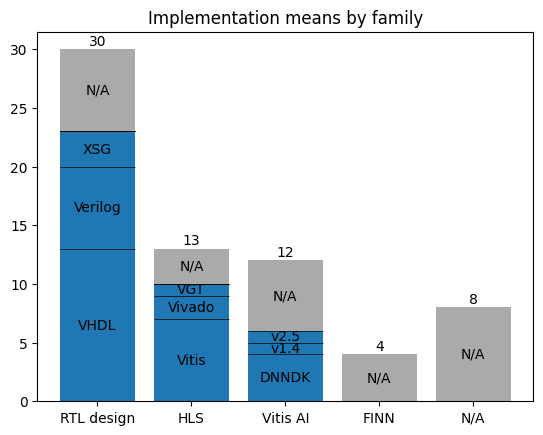

In [2]:
def barPlot_implMeans_perFamily_v1(implementationCounts) -> None:
    # --- Create Pivot Table ---
    # Transform the implementation counts into a DataFrame with categories and subcategories
    listImplCategories = []
    for fullTag, value in implementationCounts.items():
        mainCat = fullTag.split("(")[0].strip()
        subCat = fullTag.split("(")[1][:-1].strip() if "(" in fullTag else "N/A"
        listImplCategories.append([mainCat, subCat, value])

    implDf = pd.DataFrame(listImplCategories, columns=["Category", "SubCategory", "Count"])
    implDf = implDf.sort_values(by=["Count"])

    # Pivot the DataFrame to get the correct format for plotting
    subcatByCatCounts = implDf.pivot(index="Category", columns="SubCategory", values="Count").fillna(0)

    # --- Sort ---
    # Sort the categories: Create a 'Total' column, sort by it then drop it
    subcatByCatCounts["Total"] = subcatByCatCounts.sum(axis=1)
    subcatByCatCounts = subcatByCatCounts.sort_values(by="Total", ascending=False)
    subcatByCatCounts = subcatByCatCounts.drop(columns=["Total"])
    # Sort the catgeories by count and force the 'N/A' category on the right
    if "N/A" in subcatByCatCounts.index:
        new_index = [cat for cat in subcatByCatCounts.index if cat != "N/A"]
        subcatByCatCounts = subcatByCatCounts.reindex(new_index + ["N/A"])

    # Manually sort pivot table columns
    subcatByCatCounts = subcatByCatCounts[
        [
            "VHDL",
            "Verilog",
            "XSG",
            "Vitis",
            # "FINN", # FINN is now a category in itself
            "Vivado",
            "VGT",
            "DNNDK",
            "v1.4",
            "v2.5",
            "N/A",
        ]
    ]

    # --- Setup Plot ---
    categories = subcatByCatCounts.index
    subCategories = subcatByCatCounts.columns
    width = 0.8
    xAxisPositions = np.arange(len(categories))

    # --- Plot ---
    fig, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for i, subCat in enumerate(subCategories):
        counts = subcatByCatCounts[subCat].values
        if subCat == "N/A":
            color = "#aaaaaa"  # Gray for 'N/A'
        else:
            color = "#1f77b4"  # Default matplotlib blue
        p = ax.bar(
            xAxisPositions,
            counts,
            width,
            label=subCat,
            bottom=bottom,
            color=color,
        )
        bottom += counts
        ax.bar_label(
            p,
            labels=[f"{subCat}" if count > 0 else "" for count in counts],
            label_type="center",
        )

    # Set x-axis labels
    ax.set_xticks(xAxisPositions)
    ax.set_xticklabels(categories)

    # Add total count labels on top of each bar
    catTotalCount = subcatByCatCounts.sum(axis=1)
    for i, total in enumerate(catTotalCount):
        ax.text(xAxisPositions[i], total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between sub-categories
    catCumulativeCount = subcatByCatCounts.cumsum(axis=1)
    for idx, category in enumerate(categories):
        lineStart = xAxisPositions[idx] - width / 2
        lineStop = xAxisPositions[idx] + width / 2
        yAxisPosition = catCumulativeCount.loc[category].values
        for y in yAxisPosition[:-1]:  # Exclude the last total yAxisPosition
            if y > 0:
                ax.hlines(y, lineStart, lineStop, colors='black', linewidth=0.5)

    ax.set_title("Implementation means by family")

    plt.show()

barPlot_implMeans_perFamily_v1(datapointsDf["Implementation"].value_counts())

C:\Users\leon_ce\AppData\Local\Temp\ipykernel_6836\2168536579.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')


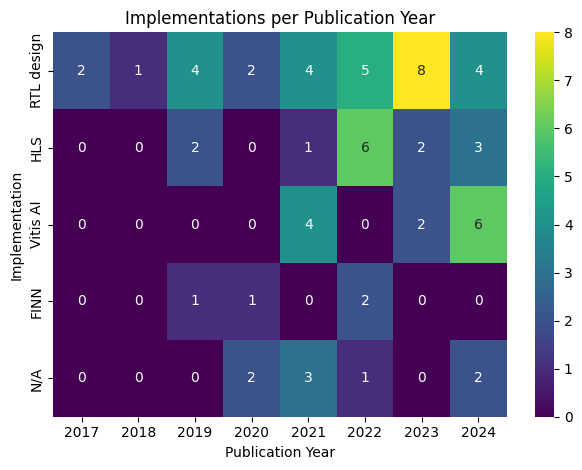

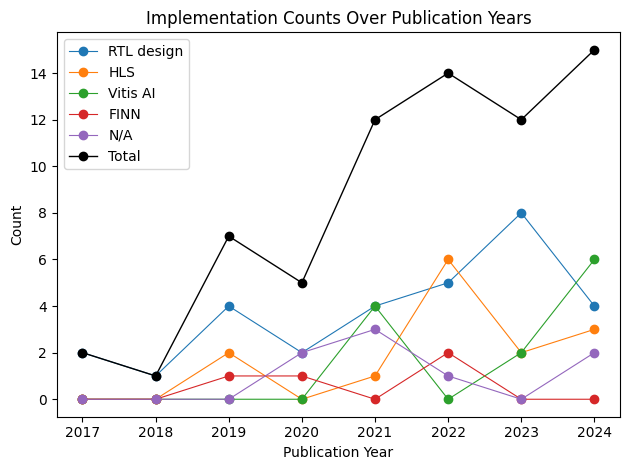

In [3]:
def heatmap_implMeans_perYear_v2(DataFrame, groupedByType=False, linePlot=False):
    """
    Plot a heatmap showing the counts of Implementations per Publication Year.
    When 'groupedByType' is True, groups implementations by their base type.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Implementation' and 'Publication year' columns.
        groupedByType (bool): If True, group implementations by their base type.
    """
    # Copy the DataFrame to avoid modifying the original data
    df = DataFrame.copy()
    df['Implementation'] = df['Implementation'].apply(lambda x: x if isinstance(x, list) else [x])
    df = df.explode('Implementation')
    
    if groupedByType:
        df['Implementation'] = df['Implementation'].apply(lambda x: x.split('(')[0].strip())
        df['Implementation'] = pd.Categorical(df['Implementation'], ['RTL design', 'HLS', 'Vitis AI', 'FINN', 'N/A'])
    
    # Prepare the data
    counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')
    pivot_df = counts.pivot(index='Implementation', columns='Publication year', values='Count').fillna(0)
    
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    # Plotting
    sns.heatmap(pivot_df, annot=True, fmt='g', cmap='viridis')
    plt.title('Implementations per Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Implementation')
    plt.tight_layout()
    plt.show()

    if linePlot:
        pivot_df.loc['Total'] = pivot_df.sum()

        fig, ax = plt.subplots()
        # Plot all implementations with a thinner line
        pivot_df.drop('Total').T.plot(ax=ax, marker='o', linewidth=0.8)
        # Plot the 'Total' line thicker and in black
        pivot_df.loc['Total'].T.plot(ax=ax, marker='o', linewidth=1, color='black', label='Total')

        plt.title('Implementation Counts Over Publication Years')
        plt.xlabel('Publication Year')
        plt.ylabel('Count')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

# Without grouping:
# heatmap_implMeans_perYear_v2(allModelsDF[['Implementation', 'Publication year']], groupedByType=False)

# With grouping:
heatmap_implMeans_perYear_v2(datapointsDf[['Implementation', 'Publication year']], groupedByType=True, linePlot=True)

### FPGA Boards


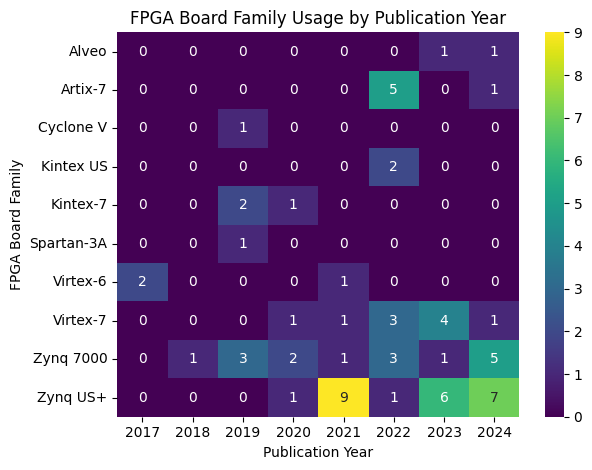

In [4]:
def heatmap_FPGA_perFamily_v1(DataFrame):
    """
    Plot a heatmap showing the number of times each FPGA board family was used per publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Board' and 'Publication year' columns.
    """

    # Copy the DataFrame to avoid modifying the original data
    DF = DataFrame.copy()

    # Extract the family from the 'Board' column
    def extract_family(board_name):
        # Assuming the format is "Family (Model)"
        if '(' in board_name:
            return board_name.split('(')[0].strip()
        else:
            return board_name.strip()

    DF['Family'] = DF['Board'].apply(extract_family)

    # Prepare the data
    # Group by 'Publication year' and 'Family', count occurrences
    Counts = DF.groupby(['Publication year', 'Family']).size().reset_index(name='Count')

    # Pivot the data to create a matrix suitable for heatmap
    PivotDF = Counts.pivot(index='Family', columns='Publication year', values='Count').fillna(0)

    # Sort the families and years for better visualization
    PivotDF = PivotDF.sort_index()
    PivotDF = PivotDF.reindex(sorted(PivotDF.columns), axis=1)  # Sort columns

    # Plotting
    sns.heatmap(PivotDF, annot=True, fmt='g', cmap='viridis')

    plt.title('FPGA Board Family Usage by Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('FPGA Board Family')

    plt.tight_layout()
    plt.show()

heatmap_FPGA_perFamily_v1(datapointsDf[['Board', 'Publication year']])

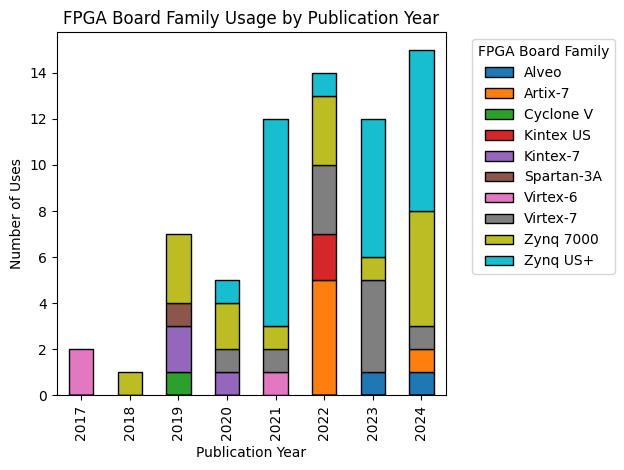

In [5]:
def barPlot_FPGA_perYear_v1(DataFrame):
    """
    Plot a stacked bar chart showing the number of times each FPGA board family was used per publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Board' and 'Publication year' columns.
    """
    # Copy the DataFrame to avoid modifying the original data
    df = DataFrame.copy()

    # Extract the family from the 'Board' column
    def extract_family(board_name):
        # Assuming the format is "Family (Model)"
        if '(' in board_name:
            return board_name.split('(')[0].strip()
        else:
            return board_name.strip()

    df['Family'] = df['Board'].apply(extract_family)

    # Group by 'Publication year' and 'Family', count occurrences
    counts = df.groupby(['Publication year', 'Family']).size().reset_index(name='Count')

    # Pivot the data to create a DataFrame suitable for plotting
    pivot_df = counts.pivot(index='Publication year', columns='Family', values='Count').fillna(0)

    # Sort the years and families
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.sort_index(axis=1)

    # Plotting
    ax = pivot_df.plot(kind='bar', stacked=True, edgecolor='black')

    plt.title('FPGA Board Family Usage by Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Number of Uses')
    plt.legend(title='FPGA Board Family', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

barPlot_FPGA_perYear_v1(datapointsDf[['Board', 'Publication year']])

### ML models


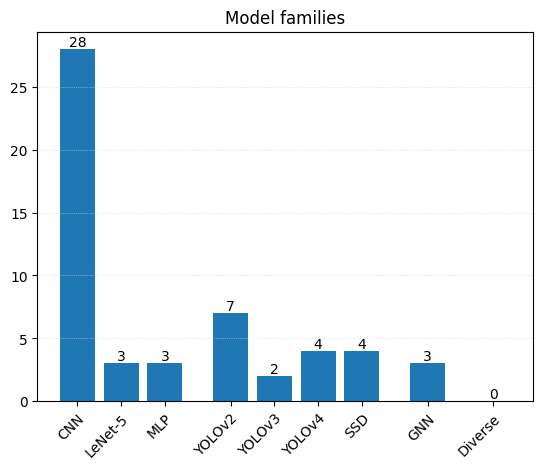

In [6]:
def barPlot_equivalentModel_v1(modelCounts):
    # --- Prepare Data ---
    # Combine categories with only one count into 'Diverse'
    modelCounts = modelCounts.copy()
    modelCounts = modelCounts[modelCounts > 1]
    modelCounts["Diverse"] = modelCounts[modelCounts == 1].sum()

    # --- Sort ---
    # Define the order of the bars by ML task family
    taskFamilies: dict[str, list[str]] = {
        "Classification": [
            "CNN",
            "LeNet-5",
            "MLP",
            "VGG16",
            "VGG11",
            "AlexNet",
            "ResNet-34",
            "MobileNetv1",
        ],
        "Object Detection": [
            "YOLOv2",
            "YOLOv3",
            "YOLOv4",
            "YOLOv4-tiny",
            "SSD300-HW",
            "SSD",
        ],
        "Other tasks": ["GNN", "SVM", "U-Net", "IORN4"],
        "Diverse": ["Diverse"],
    }
    # Unroll task families into order
    order: list[str] = [model for task in taskFamilies.values() for model in task]
    # Reorder the modelCounts according to the specified order
    modelCounts = modelCounts.reindex(order).dropna()

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors: list[str] = [
        "#2066a8",  # Blues for Classification
        "#4B93BA",
        "#8cc5e3",
        "#AFD8ED",
        "#A71313",  # Reds for Object Detection
        "#af2c2c",
        "#c46666",
        "#E18A8A",
        "#F7ABAB",
        "#1f6f6f",  # Teals for diverse boards
        "#54a1a1",
        "#aaaaaa",  # Gray for Diverse
        # "#9fc8c8", # Last teal variation
    ]

    # Define positions with gaps between task families
    positions = []
    gap = 0.5  # Define the gap size
    currentPos = 0
    for task, family in taskFamilies.items():
        for model in family:
            if model in modelCounts.index:
                positions.append(currentPos)
                currentPos += 1
        currentPos += gap

    # --- Plot ---
    fig, ax = plt.subplots()
    bars = ax.bar(positions, modelCounts.values)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle=":", linewidth=0.5, color="lightgray")

    ax.set_title("Model families")

    # Rotate x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(
        modelCounts.index, rotation=45, ha="right", rotation_mode="anchor"
    )

    plt.show()

barPlot_equivalentModel_v1(datapointsDf["Equivalent model"].value_counts())

### Datasets and Tasks


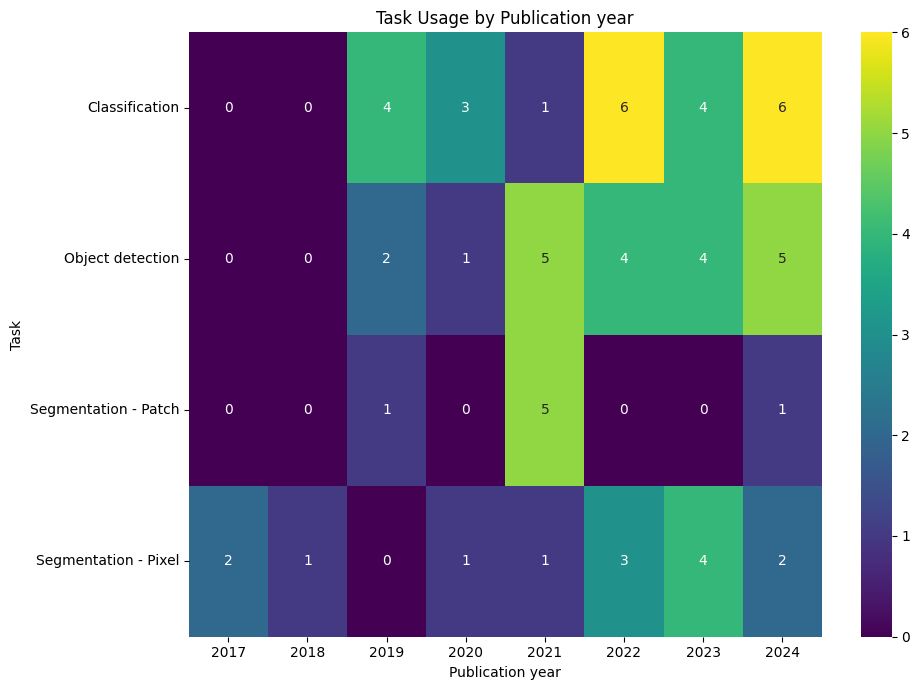

In [7]:
def plot_task_usage_heatmap(DataFrame):
    """
    Plot a heatmap showing the number of times each Task was used per Publication year.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Task' and 'Publication year' columns.
    """
    # Prepare the data
    Counts = DataFrame.groupby(['Publication year', 'Task']).size().reset_index(name='Count')
    PivotDF = Counts.pivot(index='Task', columns='Publication year', values='Count').fillna(0)
    PivotDF = PivotDF.sort_index()
    PivotDF = PivotDF.reindex(sorted(PivotDF.columns), axis=1)

    # Remove Regression
    PivotDF = PivotDF.drop('Regression', errors='ignore')

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(PivotDF, annot=True, fmt='g', cmap='viridis')
    plt.title('Task Usage by Publication year')
    # plt.xlabel('Publication year')
    # plt.ylabel('Task')
    plt.tight_layout()
    plt.show()

# Example usage
plot_task_usage_heatmap(datapointsDf[['Task', 'Publication year']])

## Higher dimensions plot


### Datasets and Tasks


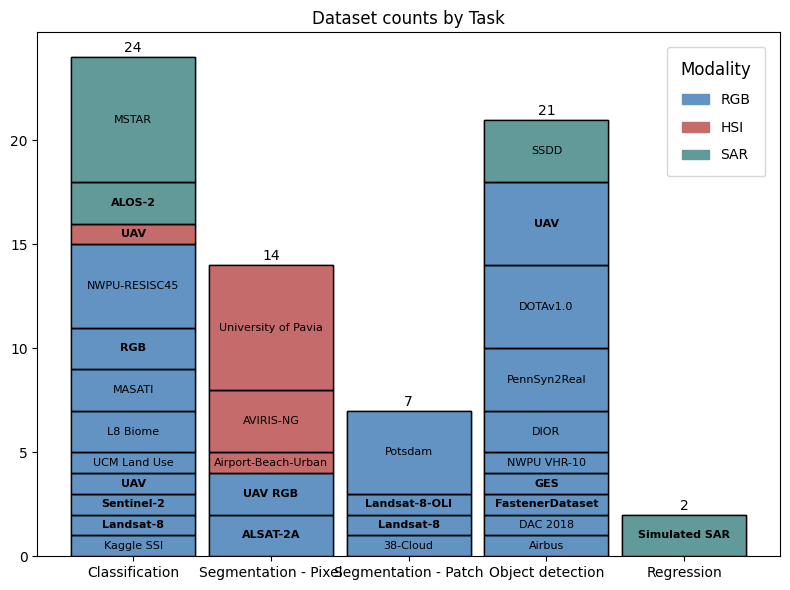

In [8]:
def plot_datasets_v2_stacked_bar_chart(dataframe):
    """_summary_
    Function to plot a stacked bar chart of datasets grouped by Task.
    Each bar represents a Task, divided into segments for each Dataset.
    Datasets within each bar are grouped by Modality and sorted by counts.
    Sub-bars are colored based on Modality.

    Args:
        dataframe (Dataframe): A DataFrame containing the columns 'Task', 'Dataset', and 'Modality'
    """
    dataframe = dataframe.copy() # avoid SettingWithCopyWarning

    # Clean some data
    dataframe['Modality'] = dataframe['Modality'].str.split('+').str[0].str.strip()
    dataframe['Dataset'] = dataframe['Dataset'].replace({
        "UAV RGB+MMW (cust.) {Object Detection}": "UAV (cust.) {Object Detection}",
        "UAV RGB (cust.) {Object Detection}": "UAV (cust.) {Object Detection}",
        "UAV RGB (cust.) {Classification}": "UAV (cust.) {Classification}",
        "UAV RGB (cust.) {Pixel classification}": "UAV (cust.) {Pixel classification}",
        "UC-Merced Land Use {Classification}": "UCM Land Use {Classification}",
        "Google Earth Studio RGB (sim.) {Object Detection}": "GES (sim.) {Object Detection}",
        "SAR (sim.) {Regression}": "Simulated SAR (sim.) {Regression}",
    })

    # Identify customized or simulated datasets
    customOrSimulatedDatasets = []
    for dataset in dataframe['Dataset'].unique():
        datasetName = dataset.split(' {')[0].strip()
        if "(cust" in dataset or "(sim" in dataset:
            customOrSimulatedDatasets.append(dataset.split(' (')[0].strip())

    datasetCounts = dataframe.groupby(['Task', 'Dataset', 'Modality']).size().reset_index(name='Count')
    
    from utils.metadata import cv_task_colors
    taskOrder = cv_task_colors.keys()
    
    modalityOrder = ['RGB', 'HSI', 'SAR']
    otherModalities = [mod for mod in dataframe['Modality'].unique() if mod not in modalityOrder]
    modalityOrder.extend(otherModalities)
    
    modalityColors = {
        'RGB': '#6293c2',
        'HSI': '#c66b6b', 
        'SAR': '#629a9a',
        '1D': '#bbd8d8',
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    barWidth = 0.9  # Make the bars wider
    xPositions = np.arange(len(taskOrder))

    TotalCounts = datasetCounts.groupby('Task')['Count'].sum().reindex(taskOrder).tolist()

    for index, task in enumerate(taskOrder):
        # Get datasets and counts for this task
        taskData = datasetCounts[datasetCounts['Task'] == task].copy()

        # Sort datasets by Modality and counts in ascending order
        taskData['ModalityOrder'] = taskData['Modality'].apply(
            lambda m: modalityOrder.index(m) if m in modalityOrder else len(modalityOrder)
        )
        taskData = taskData.sort_values(['ModalityOrder', 'Count'], ascending=[True, True]).reset_index(drop=True)
        taskData = taskData.drop(columns='ModalityOrder')

        total = taskData['Count'].sum()
        # Draw the outline of the bar
        ax.bar(xPositions[index], total, width=barWidth, edgecolor='black', linewidth=1, color='white')

        # Compute cumulative counts for plotting
        counts = taskData['Count']
        cumCounts = counts.cumsum()
        cumCounts = [0] + cumCounts.tolist()

        xLeft = xPositions[index] - barWidth / 2
        xRight = xPositions[index] + barWidth / 2

        # Add colored segments and labels within the bar
        for i, row in taskData.iterrows():
            count = row['Count']
            modality = row['Modality']
            dataset = row['Dataset']
            color = modalityColors.get(modality, '#A9A9A9')
            yBottom = cumCounts[i]
            yTop = cumCounts[i + 1]

            # Draw the colored segment
            ax.bar(
                xPositions[index],
                count,
                bottom=yBottom,
                width=barWidth,
                color=color,
                edgecolor='black',
                linewidth=1
            )

            # Add label within the segment
            datasetLabel = dataset.split(' {')[0].split(' (')[0]
            yPosition = yBottom + count / 2
            if datasetLabel in customOrSimulatedDatasets:
                fontWeight = 'bold'
            else:
                fontWeight = 'normal'
            ax.text(
                xPositions[index],
                yPosition,
                datasetLabel,
                ha='center',
                va='center',
                fontsize=8,
                weight=fontWeight
            )

        # Add horizontal lines between datasets
        for y in cumCounts[1:-1]:  # Exclude first (0) and last (total)
            ax.hlines(y, xLeft, xRight, colors='black', linewidth=1)
    
    # Add total count labels on top of each yearly bar
    for i, total in enumerate(TotalCounts):
        ax.text(i, TotalCounts[i] + 0.1, f"{int(TotalCounts[i])}", ha='center', va='bottom')
    
    # Create legend for modalities in the specified order
    handles = [
        mpatches.Patch(color=modalityColors[modality], label=modality)
        for modality in modalityOrder if modality in modalityColors
    ]
    ax.legend(
        handles=handles,
        title='Modality',
        loc='upper right',
        title_fontsize=12,     # Increase the title font size
        fontsize=10,           # Increase the label font size
        borderpad=1,           # Increase the padding between the border and the content
        labelspacing=1,        # Increase the vertical space between labels
        handlelength=2,        # Increase the length of the legend handles
        handletextpad=0.8,     # Increase space between handle and text
        borderaxespad=1.05     # Increase the space between the legend and the axes
    )

    ax.set_yticks(range(0, 21, 5))
    ax.set_xticks(xPositions)
    ax.set_xticklabels(taskOrder)
    ax.set_title('Dataset counts by Task')

    plt.tight_layout()
    plt.show()

plot_datasets_v2_stacked_bar_chart(datapointsDf[['Task', 'Dataset', 'Modality']])